# Import dependencies

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
import matplotlib.pyplot as plt
import math
import re
import regex

# Device setting

In [36]:
device = torch.device("mps:0") if torch.backends.mps.is_available() else torch.device("cpu")
# In macos, using mps:0
# In windows,using cuda
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.backends.mps.is_available():
    device = torch.device("mps:0") # for MacBook
elif torch.cuda.is_available():
    device = 'cuda'
else device = 'cpu'

# Data preparation

## Download the dataset

In [3]:
torch.manual_seed(10)
# Data loading
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


--2024-03-24 23:55:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：1115394 (1.1M) [text/plain]
正在保存至: “input.txt.11”

input.txt.11        100%[===================>]   1.06M  3.49MB/s  用时 0.3s      

2024-03-24 23:55:07 (3.49 MB/s) - 已保存 “input.txt.11” [1115394/1115394])



## Explore the dataset

In [4]:
# Reading the database file
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [8]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(vocab_size)

print('vocab:', chars)

65
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Data tokenization

We try three tokenization methods on the data set.  Firstly, we use naive tokenrization method.

In [ ]:
# Naive Tokenrization

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

Then, we use Byte Pair Encoding (BPE) method without and with regularization.

In [4]:
# Tokenrization by BPE
class BytePairEncoding:
    def __init__(self, text, vocab_size=306):
        self.vocab_size = vocab_size
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        self.merges = {}
        self._build_vocab(text)

    def _get_stats(self, ids):
        # Assuming get_stats function's implementation is provided elsewhere in your code
        stats = {}
        for i in range(len(ids)-1):
            pair = (ids[i], ids[i+1])
            if pair in stats:
                stats[pair] += 1
            else:
                stats[pair] = 1
        return stats



    def merge(self, ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids

    def _build_vocab(self, text):
        tokens = text.encode("utf-8")
        tokens = list(map(int, tokens))
        num_merges = self.vocab_size - 256
        ids = list(tokens)
        for i in range(num_merges):
            stats = self._get_stats(ids)
            pair = max(stats, key=stats.get)
            idx = 256 + i
            print(f"merging {pair} into a new token {idx}")
            ids = self.merge(ids, pair, idx)
            self.merges[pair] = idx
            self.vocab[idx] = self.vocab[pair[0]] + self.vocab[pair[1]]

    def encode(self, text):
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2:
            stats = self._get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break
            idx = self.merges[pair]
            tokens = self.merge(tokens, pair, idx)
        return tokens

    def decode(self, ids):
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text



bpe = BytePairEncoding(text)



merging (101, 32) into a new token 256
merging (116, 104) into a new token 257
merging (116, 32) into a new token 258
merging (115, 32) into a new token 259
merging (100, 32) into a new token 260
merging (44, 32) into a new token 261
merging (111, 117) into a new token 262
merging (101, 114) into a new token 263
merging (105, 110) into a new token 264
merging (121, 32) into a new token 265
merging (97, 110) into a new token 266
merging (58, 10) into a new token 267
merging (111, 114) into a new token 268
merging (111, 32) into a new token 269
merging (101, 110) into a new token 270
merging (10, 10) into a new token 271
merging (97, 114) into a new token 272
merging (32, 257) into a new token 273
merging (111, 110) into a new token 274
merging (108, 108) into a new token 275
merging (104, 97) into a new token 276
merging (44, 10) into a new token 277
merging (46, 271) into a new token 278
merging (105, 259) into a new token 279
merging (101, 115) into a new token 280
merging (121, 262) 

In [3]:
# Tokenrization by BPE with regularization


class BytePairEncoding:
    def __init__(self, text, vocab_size=306):
        self.vocab_size = vocab_size
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        self.merges = {}
        self.gpt2pat = regex.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""") # Regularization
        self._build_vocab(text)

    def _get_stats(self, ids):
        # Assuming get_stats function's implementation is provided elsewhere in your code
        stats = {}
        for i in range(len(ids)-1):
            pair = (ids[i], ids[i+1])
            if pair in stats:
                stats[pair] += 1
            else:
                stats[pair] = 1
        return stats



    def merge(self, ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids

    def _preprocess_text(self, text):
        # Using regularization
        tokens = regex.findall(self.gpt2pat, text)
        # Transform tokens to utf-8
        tokens = [token.encode('utf-8') for token in tokens]
        flat_tokens = [int(byte) for token in tokens for byte in token]
        return flat_tokens

    def _build_vocab(self, text):
        tokens = self._preprocess_text(text)
        num_merges = self.vocab_size - 256
        ids = list(tokens)
        for i in range(num_merges):
            stats = self._get_stats(ids)
            pair = max(stats, key=stats.get)
            idx = 256 + i
            print(f"merging {pair} into a new token {idx}")
            ids = self.merge(ids, pair, idx)
            self.merges[pair] = idx
            self.vocab[idx] = self.vocab[pair[0]] + self.vocab[pair[1]]

    def encode(self, text):
        tokens = self._preprocess_text(text)
        while len(tokens) >= 2:
            stats = self._get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break
            idx = self.merges[pair]
            tokens = self.merge(tokens, pair, idx)
        return tokens

    def decode(self, ids):
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text



bpe_re = BytePairEncoding(text)



merging (101, 32) into a new token 256
merging (116, 104) into a new token 257
merging (116, 32) into a new token 258
merging (115, 32) into a new token 259
merging (100, 32) into a new token 260
merging (44, 32) into a new token 261
merging (111, 117) into a new token 262
merging (101, 114) into a new token 263
merging (105, 110) into a new token 264
merging (121, 32) into a new token 265
merging (97, 110) into a new token 266
merging (58, 10) into a new token 267
merging (111, 114) into a new token 268
merging (111, 32) into a new token 269
merging (101, 110) into a new token 270
merging (10, 10) into a new token 271
merging (97, 114) into a new token 272
merging (32, 257) into a new token 273
merging (111, 110) into a new token 274
merging (108, 108) into a new token 275
merging (104, 97) into a new token 276
merging (44, 10) into a new token 277
merging (46, 271) into a new token 278
merging (105, 259) into a new token 279
merging (101, 115) into a new token 280
merging (121, 262) 

## Split the data set

In [5]:
# Split the data set

def split_data(data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):


    # Calculate split sizes
    total_size = len(data)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size  # Ensure we use all data

    # Split the data
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data


# Split the data set into train_data, val_data, test_data
data = torch.tensor(bpe.encode(text), dtype=torch.long)
train_data, val_data, test_data = split_data(data)




## Batching


In [ ]:
def get_batch(data, batch_size, block_size):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Mini-GPT architecture

In [41]:

class Head(nn.Module):
    
    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedFoward(n_embd,dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)


    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class MiniGPTModel(nn.Module):
    
    def __init__(self, n_embd, n_layer, n_head, block_size, dropout,vocab_size=306):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss 

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


# Training and experiments

In [93]:
@torch.no_grad()
def estimate_loss(model, eval_iters, batch_size, block_size, data):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(data, batch_size, block_size)  
        logits, loss = model(X, Y)
        losses[k] = loss.item()
    model.train()
    return losses.mean()  

def train_model(config, max_iters = 5000):
    
   
    model = MiniGPTModel(
        n_embd=config['n_embd'],
        n_head=config['n_head'],
        n_layer=config['n_layer'],
        block_size=config['block_size'],
        dropout =config['dropout']
    ).to(device)
    
    print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])
    
    eval_interval = 100
    eval_iters = 200
    train_losses = []
    val_losses = []

    # Setting early-stopping
    patience = 10  
    patience_counter = 0  
    best_val_loss = float('inf')  

    for iter in range(max_iters):
        

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses_train = estimate_loss(model,eval_iters, config['batch_size'], config['block_size'], train_data)
            losses_val = estimate_loss(model,eval_iters, config['batch_size'], config['block_size'], val_data)
            
            print(f"step {iter}: train loss {losses_train:.4f}, val loss {losses_val:.4f}")
            
            train_losses.append((iter, losses_train))
            val_losses.append((iter, losses_val))
            

            # check whether the val_loss improves
            current_val_loss = losses_val
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                patience_counter = 0  
            else:
                patience_counter += 1  

        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {iter + 1} iterations.")
            break
            
           
        xb, yb = get_batch(train_data, config['batch_size'], config['block_size'])
            
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


    return model, best_val_loss, train_losses, val_losses

        

## Try the model

In [79]:
# Train the model and check what generate
# hyperparameters

config_1 = {
    'n_embd': 64,
    'n_head': 4,
    'n_layer': 4,
    'block_size': 32,
    'dropout': 0.0,
    'batch_size': 16,
    'learning_rate': 0.001
}
  
m, _, _, _ = train_model(config_1)
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(bpe.decode(m.generate(context, max_new_tokens=2000)[0].tolist()))




0.240818 M parameters
step 0: train loss 5.9291, val loss 5.9210
step 100: train loss 4.1075, val loss 4.0993
step 200: train loss 3.4831, val loss 3.5045
step 300: train loss 3.2993, val loss 3.3361
step 400: train loss 3.2133, val loss 3.2590
step 500: train loss 3.1470, val loss 3.1898
step 600: train loss 3.0737, val loss 3.1369
step 700: train loss 3.0301, val loss 3.1103
step 800: train loss 2.9613, val loss 3.0482
step 900: train loss 2.9234, val loss 3.0105
step 1000: train loss 2.8852, val loss 2.9758
step 1100: train loss 2.8417, val loss 2.9367
step 1200: train loss 2.7967, val loss 2.8969
step 1300: train loss 2.7620, val loss 2.8969
step 1400: train loss 2.7251, val loss 2.8516
step 1500: train loss 2.6903, val loss 2.8259
step 1600: train loss 2.6676, val loss 2.7966
step 1700: train loss 2.6436, val loss 2.7733
step 1800: train loss 2.6005, val loss 2.7517
step 1900: train loss 2.5838, val loss 2.7427
step 2000: train loss 2.5582, val loss 2.7270
step 2100: train loss 2.

## Tuning hyperparameters

In [63]:
# Tuning hyperparameters

def random_search(hyperparameters_space, n_iter=10):

    best_loss = float('inf')
    best_config = None
    for i in range(n_iter):
        config = {k: random.choice(v) for k, v in hyperparameters_space.items()}
        print(f"Testing config: {config}")
        _, val_loss, _, _ = train_model(config)
        if val_loss < best_loss:
            best_loss = val_loss
            best_config = config
            print(f"New best config: {config} with loss: {best_loss}")
    return best_config, best_loss

# Random search
hyperparameters_space = {
    'batch_size': [16, 32, 64],
    'block_size': [16, 32, 64],
    'learning_rate': [1e-3,1e-4,1e-5],
    'n_embd': [144, 288, 576],
    'n_head': [4, 6, 8],
    'n_layer': [4, 6, 8],
    'dropout':[0.1, 0.2, 0.3]
    
}

best_config, best_loss = random_search(hyperparameters_space, n_iter=10)
print(f"Best config: {best_config} with loss: {best_loss}")

Testing config: {'batch_size': 16, 'block_size': 16, 'learning_rate': 0.0001, 'n_embd': 288, 'n_head': 6, 'n_layer': 4, 'dropout': 0.3}
step 0: train loss 5.9302, val loss 5.9261
step 100: train loss 4.3197, val loss 4.3223
step 200: train loss 3.8575, val loss 3.8858
step 300: train loss 3.5220, val loss 3.5567
step 400: train loss 3.3891, val loss 3.4147
step 500: train loss 3.2996, val loss 3.3318
step 600: train loss 3.2421, val loss 3.2923
step 700: train loss 3.1930, val loss 3.2732
step 800: train loss 3.1528, val loss 3.2011
step 900: train loss 3.1098, val loss 3.1862
step 1000: train loss 3.0815, val loss 3.1538
step 1100: train loss 3.0538, val loss 3.1146
step 1200: train loss 3.0248, val loss 3.0792
step 1300: train loss 3.0093, val loss 3.0692
step 1400: train loss 2.9908, val loss 3.0522
step 1500: train loss 2.9716, val loss 3.0495
step 1600: train loss 2.9533, val loss 3.0288
step 1700: train loss 2.9276, val loss 3.0171
step 1800: train loss 2.9130, val loss 2.9842
st

4.188402 M parameters
step 0: train loss 5.9022, val loss 5.8971
step 100: train loss 3.0628, val loss 3.1366
step 200: train loss 2.6980, val loss 2.8091
step 300: train loss 2.4749, val loss 2.6383
step 400: train loss 2.3498, val loss 2.5352
step 500: train loss 2.2581, val loss 2.4753
step 600: train loss 2.1958, val loss 2.3979
step 700: train loss 2.1479, val loss 2.3589
step 800: train loss 2.1079, val loss 2.3269
step 900: train loss 2.0657, val loss 2.3063
step 1000: train loss 2.0407, val loss 2.3037
step 1100: train loss 2.0080, val loss 2.2604
step 1200: train loss 1.9919, val loss 2.2560
step 1300: train loss 1.9670, val loss 2.2358
step 1400: train loss 1.9509, val loss 2.2257
step 1500: train loss 1.9302, val loss 2.2147
step 1600: train loss 1.9123, val loss 2.2098
step 1700: train loss 1.9030, val loss 2.1921
step 1800: train loss 1.8870, val loss 2.2002
step 1900: train loss 1.8804, val loss 2.1939
step 2000: train loss 1.8637, val loss 2.1704
step 2100: train loss 1.

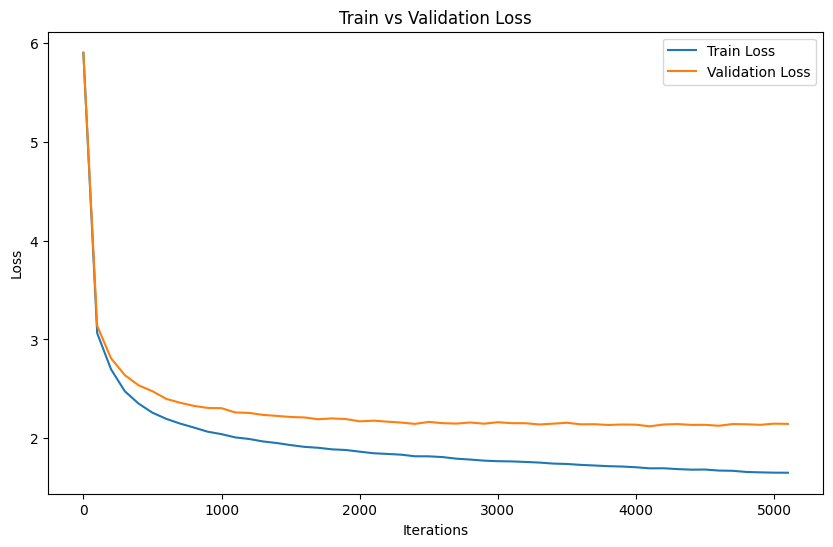

In [94]:
#Using the best hyberparameters to train the model

model, best_val_loss, train_losses, val_losses = train_model(best_config, 10000)


train_steps, train_losses = zip(*train_losses)
val_steps, val_losses = zip(*val_losses)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(val_steps, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# Results

In [99]:
# Test on the unseen data

# Evaluate the performance
avg_loss = estimate_loss(model , 200, best_config['batch_size'], best_config['block_size'], test_data)
perplexity = torch.exp(avg_loss)  
bpc_bpw = avg_loss / math.log(2) 

print(f"Average Loss: {avg_loss:.4f}, BPC/BPW: {bpc_bpw:.4f}, Perplexity: {perplexity:.4f}")


Average Loss: 2.1481, BPC/BPW: 3.0990, Perplexity: 8.5682


In [98]:
# generate from the model
context_best = torch.zeros((1, 1), dtype=torch.long, device=device)
print(bpe.decode(model.generate(context_best, max_new_tokens=2000)[0].tolist()))


 mself.

LADY CAPULET:
He news the devotching are at famous' couses!
Fainted Henry, but surpent, when continued
My embitched his deeding calls upon your honourHis couns.

SICINIUS:
Romeo! how dare the branchion.
Of so are as we but wash majesty beam
Call these intentsice of the Tower,
Whose faith to murder thee cost access
He deliver, in the father of my spoil,
We will make a scembr of your country?

EXTOP:
My son

ESCALUDIO:
Fell, my lord, shall be at his friends.

NORTHUMBERLAND:
A kingdom, and you further who is purdcoated now else.
And here be found. Prithee, came and no mortal cuqual feetch!
Not weeping tears both give heard, or either disors
many words: addesperated these weaks tears,
Takest birds for her cause hath sbecomed;
That now arise mars: most rebed my noble hath best,
With honour sins. Wantons on a littled grave:
The plain earnest all by faul brain thy tlews:
No, she signs to remembers from brother fromows?

Lord:
Speak, my lord, say I beget, pray.

WARWICK:
Why, say now